TODO:
- Testing to verify that head angle at trial start is correct (Then all head angle to wall code is verified correct)

In [108]:
%load_ext autoreload
%autoreload 2
import data_extraction.get_indices as get_indices
import parse_data.prepare_data as prepare_data
import globals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from plotting import plot_octagon, plot_trajectory
import data_extraction.get_indices as get_indices
import plotting.plot_probability_chose_wall as plot_probability_chose_wall
import data_strings
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import analysis.wall_choice as wall_choice
import data_extraction.extract_trial as extract_trial
import utils.pad_and_reshape_array as utils
import plotting.wall_visibility_order_testing_functions as wall_visibility_order_testing_functions
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# notebook global variables

wall_sep = None
trial_type = globals.HIGH_LOW
player_id = 0
n_cols = 12

In [110]:
# prepare the data

data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

# specify session number
json_filename = json_filenames_all_social[3]

_, trial_list = prepare_data.prepare_data(data_folder, json_filename, combine=True)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.


In [111]:
# filter the trial list for trialtype and wallsep

# filter trial list for given_wallLow trialtype
trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
trial_list_filtered = [trial_list[i] for i in trial_indices]

# filter trial list for wall separations if specified
if wall_sep:
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list_filtered, wall_sep=wall_sep)
    trial_list_filtered = [trial_list_filtered[i] for i in trial_indices]


In [112]:
# gather data for session

# get a full trial list of flipped and rotated trials for this session
trial_list_flipped_rotated = []
for i in range(len(trial_list_filtered)):
    trial_list_flipped_rotated.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=0))

# get walls and choice for session
high_walls_session = np.full(len(trial_list_filtered), np.nan, dtype=float)
low_walls_session = np.full(len(trial_list_filtered), np.nan, dtype=float)
for i,trial in enumerate(trial_list_filtered):
    walls = get_indices.get_walls(trial_list=trial_list_filtered, trial_index=i)
    high_walls_session[i] = walls[0]
    low_walls_session[i] = walls[1]

chosen_walls_session = get_indices.get_chosen_walls(trial_list_filtered)


In [113]:
def get_trajectory_information_trial(trial_list, trial_index, chosen_walls_session, player_id=0):
    '''gather data for head angle and wall vector plots''' 

    # get trial
    trial = extract_trial.extract_trial(trial_list=trial_list, trial_index=trial_index, trial=None)

    # trajectory 
    trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)

    # trial rotation angle
    rotation_angle_trial = flip_rotate_trajectories.find_rotation_angle_trial(trial_list, trial_index)

    rotated_flipped_trial = flip_rotate_trajectories.flip_rotate_trajectories(trial_list, trial_index)

    # trial walls
    walls = get_indices.get_walls(trial_list=trial_list, trial_index=trial_index)
    chosen_wall = chosen_walls_session[trial_index]


    return (trial, rotation_angle_trial, rotated_flipped_trial, walls, chosen_wall)

In [114]:
# # reshape relevant arrays to fit with n_rows,n_cols grid (pad with np.nan) 

high_walls_session_reshaped = utils.pad_and_reshape_array(high_walls_session, n_cols)
low_walls_session_reshaped = utils.pad_and_reshape_array(low_walls_session, n_cols)
chosen_walls_session_reshaped = utils.pad_and_reshape_array(chosen_walls_session, n_cols)


In [115]:
# plot single trial

def plot_octagon_trajectories(trial, rotated_flipped_trial, label=False, axes=None):
        
    axes[0] = plot_octagon.plot_octagon(ax=axes[0])
    axes[1] = plot_octagon.plot_octagon(ax=axes[1])

    axes[0] = plot_trajectory.plot_trial_trajectory(axes[0], trial=trial, label=label)
    axes[1] = plot_trajectory.plot_trial_trajectory(axes[1], trial=rotated_flipped_trial, label=label)

    # change plot params
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)
            ax.tick_params(left=False, bottom=False)  # Turn off major ticks
            ax.set_xticklabels([])
            ax.set_yticklabels([])



In [116]:
def plot_single_trial_flip_rotate_trajectories(trial_list, chosen_walls_session, trial_index, player_id=0):

    fig, axes = plt.subplots(1,2)

    # get trajectory information
    (trial, rotation_angle_trial, rotated_flipped_trial, walls, chosen_wall) = get_trajectory_information_trial(trial_list, trial_index,
                                                                                                                 chosen_walls_session, player_id=player_id)

    # plot trajectories for this trial
    axes = plot_octagon_trajectories(trial, rotated_flipped_trial, label=False, axes=axes)

    # show the plot
    plt.show()

    # return the High wall, Low wall, and chosen wall on this trial
    return (walls[0], walls[1], int(chosen_wall))




In [117]:
def plot_multiple_trials_flip_rotate_trajectories(trial_list, chosen_walls_session, rows=12, cols=12, trial_num_offset=0, player_id=0,
                                               vector_length=20, wall_index=None, start_index=0):
    ''' Display a rows,cols figure of subplots showing the flipped and rotated trajectories for both players in single trials.
        Plots are in pairs, with the first plotted being pre-flip and the second being post-flip.
        Takes trial list. '''

    fig, axes = plt.subplots(rows,cols, figsize=(20,20))
    index_out_of_range_flag = False
    exception_text = None


    # loop through each trial index
    for i in range(rows):
        # loop through -1 as we plot 2 subplots per loop
        for j in range(0,cols,2):
            trial_index = i*rows + j + trial_num_offset

            try:
                # get trajectory information
                (trial, rotation_angle_trial, rotated_flipped_trial, walls,
                    chosen_wall) = get_trajectory_information_trial(trial_list, trial_index=trial_index,
                                                                                        chosen_walls_session=chosen_walls_session,
                                                                                            player_id=player_id)

                    
            except Exception as e:
                index_out_of_range_flag = True
                exception_text = e
                axes[i, j].axis('off')
                axes[i, j+1].axis('off')
                continue
            
            
            # plot visualisation vectors for this trial
            axes[i,j:j+2] = plot_octagon_trajectories(trial, rotated_flipped_trial, label=False, axes=axes[i,j:j+2])

            
    if index_out_of_range_flag:
        print(f"Exception: {exception_text}, no trials left?")
    
    # adjust layout to prevent overlap
    plt.tight_layout()

    # show the plot
    plt.show()


In [118]:
trial_index = 0

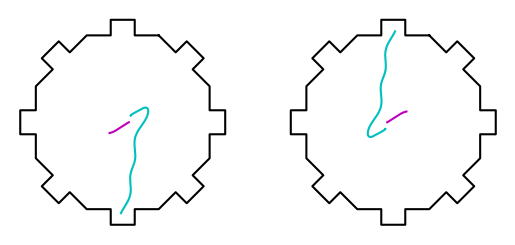

High wall, Low wall, and Chosen wall are: 5, 6, 5


In [119]:
(high, low, chosen) = plot_single_trial_flip_rotate_trajectories(trial_list_filtered, chosen_walls_session, trial_index=trial_index, player_id=0)
print(f"High wall, Low wall, and Chosen wall are: {high}, {low}, {chosen}")

Exception: list index out of range, no trials left?


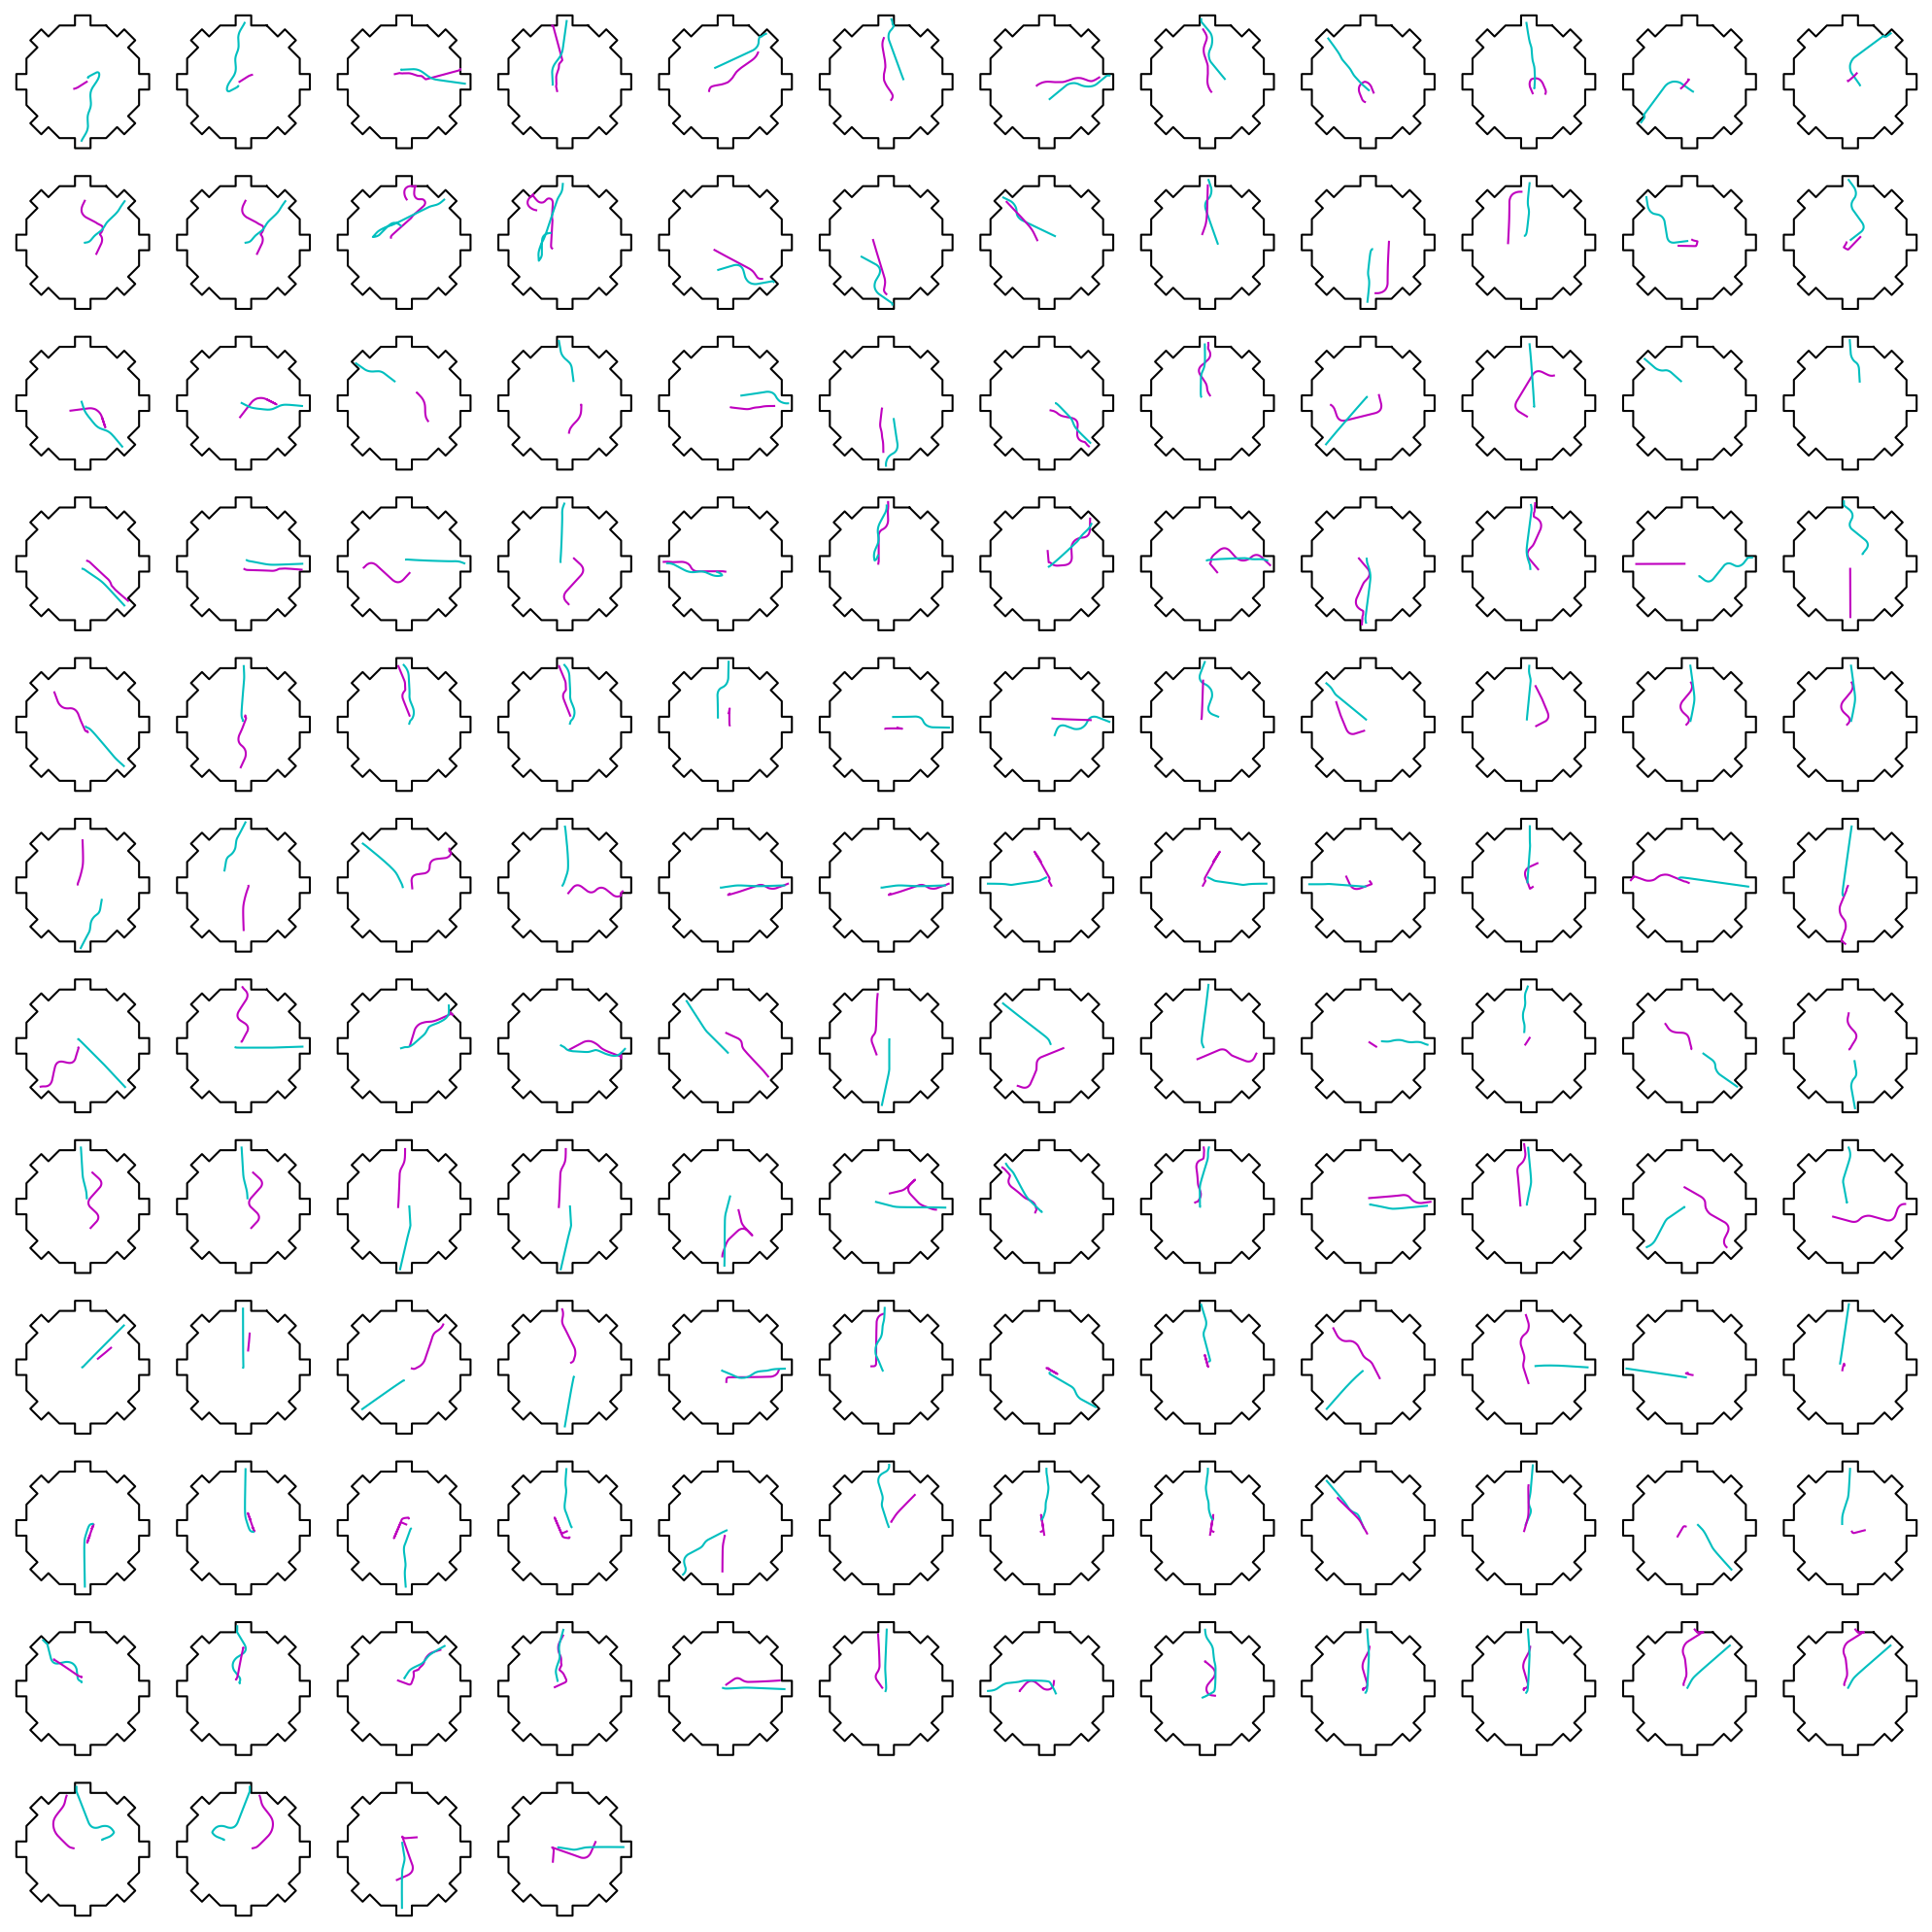

In [120]:
plot_multiple_trials_flip_rotate_trajectories(trial_list_filtered, chosen_walls_session, player_id=0)

In [121]:
print(f"High wall:\n {high_walls_session_reshaped}\n"), 
print(f"Low wall:\n {low_walls_session_reshaped}\n") 
print(f"Trial chosen wall:\n {chosen_walls_session_reshaped}")

High wall:
 [[ 5.  1.  3.  3.  2.  7.  3.  6.  8.  1.  7.  1.]
 [ 1.  6.  2.  7.  8.  2.  8.  4.  5.  8.  8.  2.]
 [ 2.  2.  8.  4.  7.  5.  4.  4.  6.  8.  8.  6.]
 [ 6.  8.  3.  5.  7.  8.  4.  8.  5.  7.  3.  1.]
 [ 4.  3.  1.  8.  7.  7.  3.  8.  8.  6.  1.  6.]
 [ 5.  2.  8.  5.  1.  3.  1.  6.  7.  7.  3.  1.]
 [ 6.  1.  8.  6.  4.  5.  8.  4.  3.  1.  8.  4.]
 [ 1.  6.  1.  5.  3.  5.  8.  7.  3.  6.  6.  7.]
 [ 2.  1.  2.  5.  3.  7.  4.  4.  8.  2.  7.  6.]
 [ 5.  3.  5.  7.  6.  1.  1.  8.  8.  6.  4.  4.]
 [ 8.  3.  2.  4.  3.  6.  7.  8.  1.  7.  1.  3.]
 [ 1.  4.  7.  4. nan nan nan nan nan nan nan nan]]

Low wall:
 [[ 6.  8.  7.  7.  1.  6.  4.  7.  7.  5.  6.  3.]
 [ 2.  2.  3.  6.  4.  3.  4.  8.  6.  4.  7.  6.]
 [ 4.  4.  4.  5.  3.  1.  8.  3.  7.  1.  4.  7.]
 [ 4.  4.  7.  6.  3.  4.  2.  6.  7.  6.  7.  3.]
 [ 8.  5.  2.  7.  1.  3.  4.  1.  7.  2.  3.  2.]
 [ 1.  4.  2.  3.  3.  7.  7.  4.  1.  3.  7.  7.]
 [ 4.  5.  2.  7.  8.  3.  6.  2.  4.  2.  4.  3.]
 [ 5. 